[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/qubvel/segmentation_models.pytorch/blob/main/examples/binary_segmentation_intro.ipynb)

🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before).

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [ ]:
%%capture
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations

In [2]:
import os

import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.optim import lr_scheduler
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import wandb
from pytorch_lightning.loggers import WandbLogger

## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [3]:
from segmentation_models_pytorch.datasets import SimpleOxfordPetDataset

In [27]:
import os
import torch
import shutil
import numpy as np

from PIL import Image
from tqdm import tqdm
from urllib.request import urlretrieve


class GrayDataset(torch.utils.data.Dataset):
    def __init__(self, root, mode="train", transform=None):
        assert mode in {"train", "valid", "test"}

        self.root = root
        self.mode = mode
        self.transform = transform

        self.images_directory = os.path.join(self.root, "images")
        self.masks_directory = os.path.join(self.root, "annotations", "trimaps")

        self.filenames = self._read_split()  # read train/valid/test splits

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.images_directory, filename + ".png")
        mask_path = os.path.join(self.masks_directory, filename + ".png")

        image = np.array(Image.open(image_path).convert("RGB"))

        trimap = np.array(Image.open(mask_path))
        mask = self._preprocess_mask(trimap)

        sample = dict(image=image, mask=mask, trimap=trimap, filename=filename)
        if self.transform is not None:
            sample = self.transform(**sample)

        return sample

    @staticmethod
    def _preprocess_mask(mask):
        mask = mask.astype(np.float32)
        mask[mask == 2.0] = 0.0
        mask[(mask == 1.0) | (mask == 3.0)] = 1.0
        return mask

    def _read_split(self):
        split_filename = "test.txt" if self.mode == "test" else "trainval.txt"
        split_filepath = os.path.join(self.root, "annotations", split_filename)
        with open(split_filepath) as f:
            split_data = f.read().strip("\n").split("\n")
        filenames = [x.split(" ")[0] for x in split_data]
        if self.mode == "train":  # 90% for train
            filenames = [x for i, x in enumerate(filenames) if i % 10 != 0]
        elif self.mode == "valid":  # 10% for validation
            filenames = [x for i, x in enumerate(filenames) if i % 10 == 0]
        return filenames

    @staticmethod
    def download(root):
        # load images
        filepath = os.path.join(root, "images.tar.gz")
        download_url(
            url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
            filepath=filepath,
        )
        extract_archive(filepath)

        # load annotations
        filepath = os.path.join(root, "annotations.tar.gz")
        download_url(
            url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz",
            filepath=filepath,
        )
        extract_archive(filepath)


class SimpleGrayDataset(GrayDataset):
    def __getitem__(self, *args, **kwargs):
        sample = super().__getitem__(*args, **kwargs)

        # resize images
        image = np.array(
            Image.fromarray(sample["image"]).resize((256, 256), Image.BILINEAR)
        )
        mask = np.array(
            Image.fromarray(sample["mask"]).resize((256, 256), Image.NEAREST)
        ).astype(np.float32) / 255.0 # normalization 0-1
        trimap = np.array(
            Image.fromarray(sample["trimap"]).resize((256, 256), Image.NEAREST)
        )

        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        sample["mask"] = np.expand_dims(mask, 0)
        sample["trimap"] = np.expand_dims(trimap, 0)

        return sample

class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        return

    with TqdmUpTo(
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
        miniters=1,
        desc=os.path.basename(filepath),
    ) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    dst_dir = os.path.splitext(filepath)[0]
    if not os.path.exists(dst_dir):
        shutil.unpack_archive(filepath, extract_dir)

In [28]:
# download data
root = "."
#SimpleGrayDataset.download(root)

In [29]:
# init train, val, test sets
train_dataset = SimpleGrayDataset(root, "train")
valid_dataset = SimpleGrayDataset(root, "valid")
test_dataset = SimpleGrayDataset(root, "test")

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=n_cpu
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=n_cpu
)
test_dataloader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=n_cpu
)

Train size: 452
Valid size: 51
Test size: 56


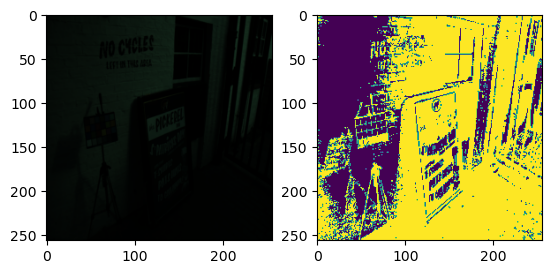

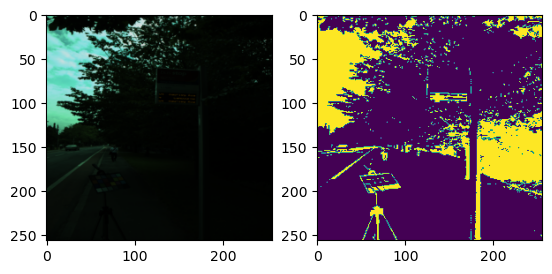

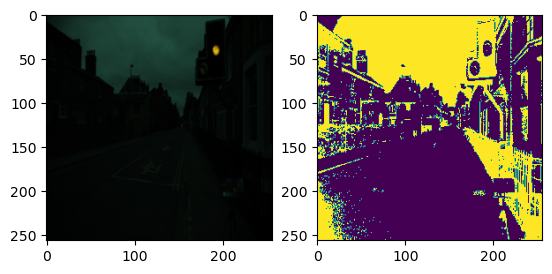

In [30]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = valid_dataset[0]
plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()

sample = test_dataset[0]
plt.subplot(1, 2, 1)
# for visualization we have to transpose back to HWC
plt.imshow(sample["image"].transpose(1, 2, 0))
plt.subplot(1, 2, 2)
# for visualization we have to remove 3rd dimension of mask
plt.imshow(sample["mask"].squeeze())
plt.show()

## Model

In [34]:
# Some training hyperparameters
EPOCHS = 3
T_MAX = EPOCHS * len(train_dataloader)
OUT_CLASSES = 1

In [32]:
class PetModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch,
            encoder_name=encoder_name,
            in_channels=in_channels,
            classes=out_classes,
            **kwargs,
            # encorder_weights=Noneを追加したりすれば、自分のモデルを追加できる？
        )
        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        # initialize step metics
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.test_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std #事前学習なしモデルは、ここスキップ
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        if batch.get("trimap", None) != None:
            del batch["trimap"]
            #print("trimap deleted") 

        mask = batch["mask"]
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0


        logits_mask = self.forward(image)

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(
            pred_mask.long(), mask.long(), mode="binary"
        )
        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(
            tp, fp, fn, tn, reduction="micro-imagewise"
        )
        
        # "per_image_iou" :  各画像ごとに IoU を計算し、平均を取る 小さい物体にも敏感、空白画像の影響が大きい
        # "dataset_iou" : 全画像をまとめて IoU を計算 データ全体の「グローバルな正解率」的なイメージ

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        train_loss_info = self.shared_step(batch, "train")
        # append the metics of each step to the
        self.training_step_outputs.append(train_loss_info)
        # 🔽 lossをWandBに記録
        self.log("train_loss", train_loss_info["loss"], on_step=True, on_epoch=True, prog_bar=True)
        return train_loss_info

    def on_train_epoch_end(self):
        self.shared_epoch_end(self.training_step_outputs, "train")
        # empty set output list
        self.training_step_outputs.clear()
        return

    def validation_step(self, batch, batch_idx):
        valid_loss_info = self.shared_step(batch, "valid")
        self.validation_step_outputs.append(valid_loss_info)
        # 🔽 validation lossをWandBに記録
        self.log("val_loss", valid_loss_info["loss"], on_step=False, on_epoch=True, prog_bar=True)
        return valid_loss_info

    def on_validation_epoch_end(self):
        self.shared_epoch_end(self.validation_step_outputs, "valid")
        self.validation_step_outputs.clear()
        return

    def test_step(self, batch, batch_idx):
        test_loss_info = self.shared_step(batch, "test")
        self.test_step_outputs.append(test_loss_info)
        # 🔽 test_loss をログに記録
        self.log("test_loss", test_loss_info["loss"], on_step=False, on_epoch=True, prog_bar=True)
        return test_loss_info

    def on_test_epoch_end(self):
        self.shared_epoch_end(self.test_step_outputs, "test")
        # empty set output list
        self.test_step_outputs.clear()
        return

    def configure_optimizers(self): # ここで最適化できます
        optimizer = torch.optim.Adam(self.parameters(), lr=2e-4)
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=1e-5)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1,
            },
        }
        return

In [35]:
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)

In [11]:
import segmentation_models_pytorch as smp
# how many models can we use? 76
print(smp.encoders.get_encoder_names())

['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d', 'resnext101_32x48d', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn107', 'dpn131', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'inceptionresnetv2', 'inceptionv4', 'efficientnet-b0', 'efficientnet-b1', 'efficientnet-b2', 'efficientnet-b3', 'efficientnet-b4', 'efficientnet-b5', 'efficientnet-b6', 'efficientnet-b7', 'mobilenet_v2', 'xception', 'timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_efficientnet_li

In [26]:
import segmentation_models_pytorch as smp

print(smp.__all__)  # 利用可能なモジュール名一覧


['datasets', 'encoders', 'decoders', 'losses', 'metrics', 'Unet', 'UnetPlusPlus', 'MAnet', 'Linknet', 'FPN', 'PSPNet', 'DeepLabV3', 'DeepLabV3Plus', 'PAN', 'UPerNet', 'Segformer', 'from_pretrained', 'create_model', '__version__']


In [ ]:
#  'Unet', 'UnetPlusPlus', 'MAnet', 'Linknet', 'FPN', 'PSPNet', 'DeepLabV3', 'DeepLabV3Plus', 'PAN', 'UPerNet', 'Segformer',

## Training

In [36]:
# プロジェクト名などを指定
wandb_logger = WandbLogger(project="test_Gray-segmentation", name="unet-resnet34-run")

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    log_every_n_steps=1,
    logger=wandb_logger,  # add wandb for loss
    precision=16
)


/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [37]:
wandb.init(project="test_Gray-segmentation", config={
    "epochs": EPOCHS,
    "arch": "FPN",
    "encoder": "resnet34",
    "lr": 2e-4,
    "batch_size": 64
})


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
test_dataset_iou,▁
test_loss,▁
test_per_image_iou,▁
train_dataset_iou,▁▃▃▄▅▆▇▇██
train_loss_epoch,█▆▅▄▄▃▂▂▁▁
train_loss_step,▇▃▃▄█▃▄▂▃▃▃▃▄▃▃▂▃▃▃▃▃▁▃▂▂▃▂▂▂▂▂▂▂▁▁▂▂▂▂▂
train_per_image_iou,▁▄▅▅▆▆▇▇██
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,█▇▄▃▂▁▁▁▁▂▂
valid_dataset_iou,▁▂▅▆▇████▇▇


wandb: WARNING Fatal error while uploading data. Some run data will not be synced, but it will still be written to disk. Use `wandb sync` at the end of the run to try uploading.


In [15]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [38]:
# trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)

/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | FPN      | 23.2 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)
175       Modules in train mode
0         Modules in eval mode


/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 51. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0:  12%|█▎        | 1/8 [00:08<01:01,  0.11it/s, v_num=wqbc, train_loss_step=0.510]

/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 0: 100%|██████████| 8/8 [00:09<00:00,  0.82it/s, v_num=wqbc, train_loss_step=0.310]

/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 2: 100%|██████████| 8/8 [00:18<00:00,  0.43it/s, v_num=wqbc, train_loss_step=0.305, val_loss=0.460, valid_per_image_iou=0.370, valid_dataset_iou=0.370, train_loss_epoch=0.438, train_per_image_iou=0.392, train_dataset_iou=0.392]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 8/8 [00:19<00:00,  0.40it/s, v_num=wqbc, train_loss_step=0.305, val_loss=0.460, valid_per_image_iou=0.370, valid_dataset_iou=0.370, train_loss_epoch=0.438, train_per_image_iou=0.392, train_dataset_iou=0.392]


## Validation and test metrics

In [40]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
print(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]
[{'val_loss': 0.4602435231208801, 'valid_per_image_iou': 0.36962801218032837, 'valid_dataset_iou': 0.36962801218032837}]


In [41]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


/home/nh11256z/conda/envs/Oxbiseg/lib/python3.9/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 56. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


[{'test_loss': 0.4488210082054138, 'test_per_image_iou': 0.38043323159217834, 'test_dataset_iou': 0.38043323159217834}]


# Save model to HF Hub

Login to [HF hub](https://huggingface.co/) if you want to save your model to the hub. Then, you will be able to save and load model, save metrics, and dataset name!

# Result visualization

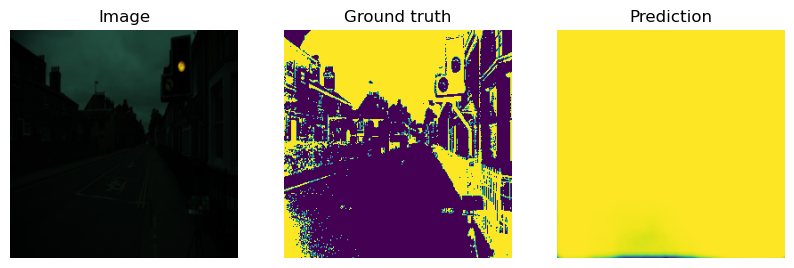

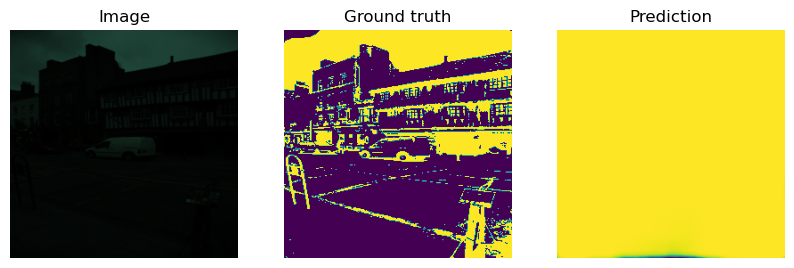

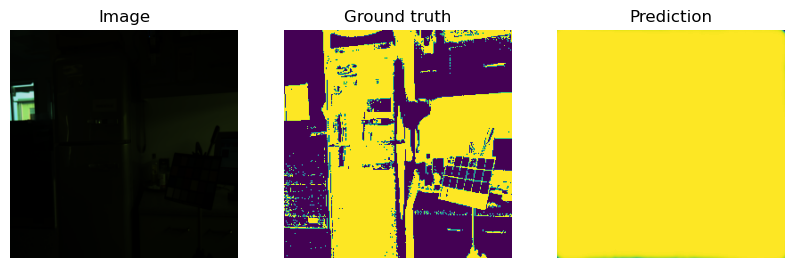

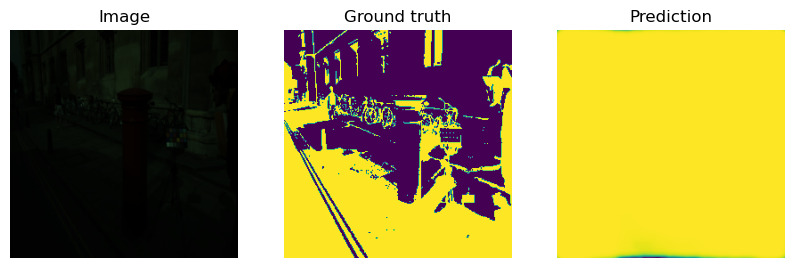

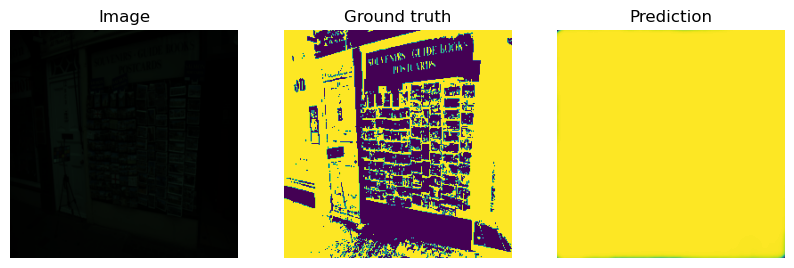

In [42]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()
for idx, (image, gt_mask, pr_mask) in enumerate(
    zip(batch["image"], batch["mask"], pr_masks)
):
    if idx <= 4:
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image.numpy().transpose(1, 2, 0))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(gt_mask.numpy().squeeze())
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pr_mask.numpy().squeeze())
        plt.title("Prediction")
        plt.axis("off")
        plt.show()
        
        wandb.log({
            f"example_{idx}": [
            wandb.Image(image.numpy().transpose(1, 2, 0), caption="Image"),
            wandb.Image(gt_mask.numpy().squeeze(), caption="GT"),
            wandb.Image(pr_mask.numpy().squeeze(), caption="Prediction"),
            ]
        })
        
    else:
        break

In [52]:
print("Batch filename:", repr(filename))
print("Available keys:", list(illum_dict.keys())[:5])  # 最初の数個だけ表示


Batch filename: 'IMG_0423.png'
Available keys: ['8D5U5524', '8D5U5525', '8D5U5526', '8D5U5527', '8D5U5528']


[0] Angular Error (degrees): 1.16


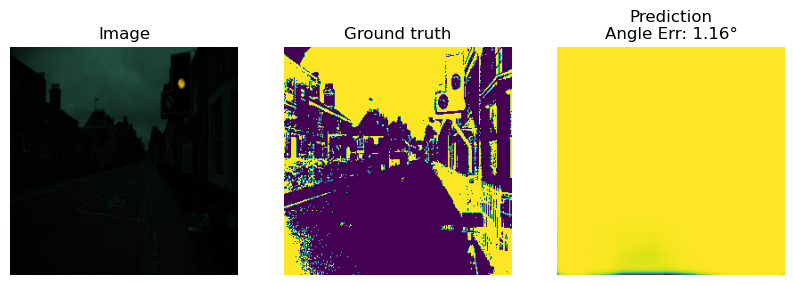

[1] Angular Error (degrees): 1.23


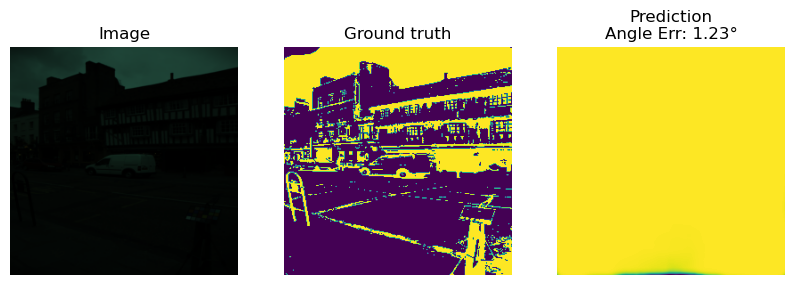

[2] Angular Error (degrees): 7.07


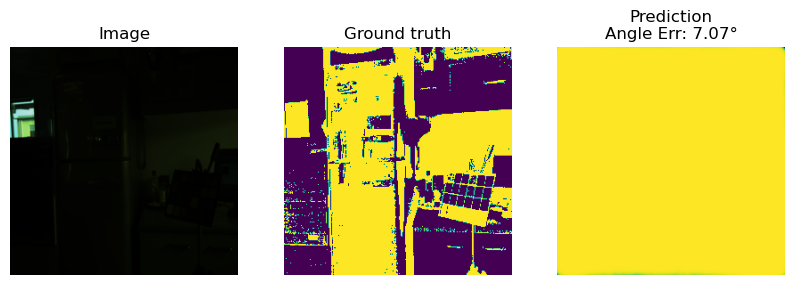

[3] Angular Error (degrees): 8.26


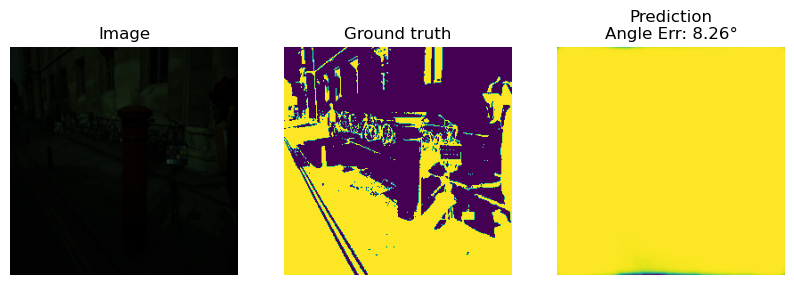

[4] Angular Error (degrees): 2.98


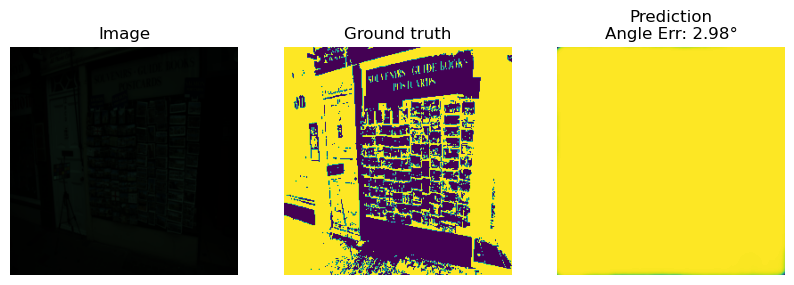

In [ ]:
import os
import pandas as pd

illum_df = pd.read_csv("real_illum.csv")

# ベースファイル名（拡張子・パスを除く）を作成
illum_df["basename"] = illum_df["image"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# 正しい列名で辞書を作成（R, G, B は大文字）
illum_dict = dict(zip(illum_df["basename"], illum_df[["r", "g", "b"]].values))


for idx in range(len(batch["image"])):
    if idx > 4:
        break

    image = batch["image"][idx]
    gt_mask = batch["mask"][idx]
    pr_mask = pr_masks[idx]

    # === ファイル名取得 ===
    filename = batch["filename"][idx]
    if isinstance(filename, bytes):
        filename = filename.decode()

    filename = os.path.splitext(os.path.basename(filename))[0]  # 拡張子とパスを除去

    if filename not in illum_dict:
        print(f"[{idx}] Filename '{filename}' not found in illum_dict")
        angular_error = None
    else:
        gt_illum = illum_dict[filename]
        gt_illum = gt_illum / np.linalg.norm(gt_illum)

        # === Angular Error 計算 === upper 50%
        binary_mask = pr_mask.squeeze().numpy() > 0.5
        img = image.permute(1, 2, 0).numpy()
        gray_pixels = img[binary_mask]

        if gray_pixels.shape[0] == 0:
            print(f"[{idx}] No gray pixels found.")
            angular_error = None
        else:
            est_illum = gray_pixels.mean(axis=0)
            est_illum /= np.linalg.norm(est_illum)

            dot = np.clip(np.dot(est_illum, gt_illum), -1.0, 1.0)
            angular_error = np.arccos(dot) * (180 / np.pi)
            print(f"[{idx}] Angular Error (degrees): {angular_error:.2f}")

    # === 画像表示 ===
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze())
    title = f"Prediction\nAngle Err: {angular_error:.2f}°" if angular_error is not None else "Prediction\n(No gray pixels)"

    plt.title(title)
    plt.axis("off")
    plt.show()

    # === wandb 保存 ===
    wandb.log({
        f"example_{idx}": [
            wandb.Image(img, caption="Image"),
            wandb.Image(gt_mask.numpy().squeeze(), caption="GT"),
            wandb.Image(pr_mask.numpy().squeeze(), caption=title),
        ]
    })


In [58]:
import os
import matplotlib.pyplot as plt

# error list
angular_errors = []
filenames_used = []

# 保存先ディレクトリ
save_dir = "predictions_fig"
os.makedirs(save_dir, exist_ok=True)

# 推論（ここはそのまま）
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

# 可視化＋保存ループ
for idx, (image, gt_mask, pr_mask) in enumerate(zip(batch["image"], batch["mask"], pr_masks)):
    # === 画像データとファイル名取得 ===
    filename = batch["filename"][idx]
    if isinstance(filename, bytes):
        filename = filename.decode()
    filename = os.path.splitext(os.path.basename(filename))[0]

    img = image.permute(1, 2, 0).numpy()
    prob_map = pr_mask.squeeze().numpy()
    binary_mask = prob_map > 0.5
    gray_pixels = img[binary_mask]

    if filename not in illum_dict or gray_pixels.shape[0] == 0:
        angular_error = None
        print(f"[{idx}] Skipped (filename not found or no gray pixels).")
    else:
        est_illum = gray_pixels.mean(axis=0)
        est_illum /= np.linalg.norm(est_illum)
        gt_illum = illum_dict[filename]
        gt_illum = gt_illum / np.linalg.norm(gt_illum)

        dot = np.clip(np.dot(est_illum, gt_illum), -1.0, 1.0)
        angular_error = np.arccos(dot) * (180 / np.pi)
        angular_errors.append(angular_error)
        filenames_used.append(filename)
        print(f"[{idx}] {filename} → Angular Error: {angular_error:.2f}°")

    # === プロットと保存 ===
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze())
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(prob_map)
    ae_str = f"{angular_error:.2f}°" if angular_error is not None else "N/A"
    plt.title(f"Prediction\nAngle Err: {ae_str}")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"{filename}_{ae_str.replace('°','')}.png"))
    plt.close()


[0] IMG_0822 → Angular Error: 1.16°
[1] IMG_0785 → Angular Error: 1.23°
[2] IMG_0578 → Angular Error: 7.07°
[3] IMG_0419 → Angular Error: 8.26°
[4] IMG_0423 → Angular Error: 2.98°
[5] IMG_0857 → Angular Error: 2.53°
[6] 8D5U5537 → Angular Error: 10.98°
[7] IMG_0325 → Angular Error: 4.92°
[8] IMG_0861 → Angular Error: 6.35°
[9] IMG_0442 → Angular Error: 4.91°
[10] IMG_0687 → Angular Error: 0.79°
[11] IMG_0745 → Angular Error: 6.45°
[12] 8D5U5594 → Angular Error: 3.38°
[13] 8D5U5567 → Angular Error: 2.56°
[14] 8D5U5570 → Angular Error: 8.98°
[15] IMG_0460 → Angular Error: 5.84°
[16] IMG_0790 → Angular Error: 3.86°
[17] IMG_0816 → Angular Error: 0.95°
[18] IMG_0615 → Angular Error: 5.05°
[19] IMG_0517 → Angular Error: 3.97°
[20] 8D5U5525 → Angular Error: 3.66°
[21] IMG_0480 → Angular Error: 6.67°
[22] IMG_0463 → Angular Error: 3.92°
[23] IMG_0526 → Angular Error: 0.38°
[24] IMG_0840 → Angular Error: 1.86°
[25] 8D5U5597 → Angular Error: 6.09°
[26] IMG_0584 → Angular Error: 3.92°
[27] IMG_0

In [59]:
if angular_errors:
    ae = np.array(angular_errors)
    ae_sorted = np.sort(ae)
    mean_ae = ae.mean()
    median_ae = np.median(ae)
    trimean_ae = (np.percentile(ae, 25) + 2 * median_ae + np.percentile(ae, 75)) / 4
    best25_mean = ae_sorted[:len(ae)//4].mean()
    worst25_mean = ae_sorted[-len(ae)//4:].mean()

    stats_df = pd.DataFrame({
        "Metric": ["Mean", "Median", "Trimean", "Best25%", "Worst25%"],
        "AngularError": [mean_ae, median_ae, trimean_ae, best25_mean, worst25_mean]
    })
    stats_df.to_csv("angular_error_stats.csv", index=False)

    per_file_df = pd.DataFrame({
        "Filename": filenames_used,
        "AngularError": angular_errors
    })
    per_file_df.to_csv("angular_error_per_file.csv", index=False)

    print("Saved angular_error_stats.csv and angular_error_per_file.csv")
else:
    print("No valid angular errors to save.")


Saved angular_error_stats.csv and angular_error_per_file.csv


In [25]:
from scipy.io import loadmat
import pandas as pd

data = loadmat('real_illum_568..mat')

# キーの一覧を見る
print(data.keys())

# Ground Truth の照明情報（例：画像数 × 3）
illuminants = data['real_rgb']
print("Shape:", illuminants.shape)

df_illum = pd.DataFrame(illuminants, columns=['R', 'G', 'B'])

#names = [str(x[0]) for x in data['__globals__'].squeeze()]
#names = [str(x) for x in data['__globals__']]
#df_illum['image_name'] = names
print(df_illum.head())



dict_keys(['__header__', '__version__', '__globals__', 'real_rgb'])
Shape: (568, 3)
        R       G       B
0   769.0  1043.0   653.0
1  1664.0  2315.0  1464.0
2   470.0   572.0   239.0
3  1413.0  1735.0   836.0
4   711.0   871.0   401.0


In [ ]:
data2 = scipy.io.loadmat('colourchecker_gamma1_bit12.mat')
print(data2.keys())
